# Plots for the 2MDM analysis

In [10]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from auxPlots import columnsDict, colorDict, defaultPars

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings

plt.rcParams.update(defaultPars) #Figure resolution

#### Get data in pcl format and print all columns names

In [11]:
#Merge with SModelS DataFrame
pclFiles = ['../data/smodels_results.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
dataDF.set_index('filename',drop=True,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'ExptRes.result0.maxcond', 'ExptRes.result0.theory prediction (fb)', 'ExptRes.result0.upper limit (fb)', 'ExptRes.result0.expected upper limit (fb)', 'ExptRes.result0.TxNames', 'ExptRes.result0.Mass (GeV)', 

#### Filter couplings

In [12]:
gchi = np.sqrt(2)
gq = 0.25
sina = 0.25
dataDF = dataDF[((np.abs(dataDF['gchi']-gchi) < 0.001) 
                 & (dataDF['gq'] == gq) & (dataDF['sina'] == sina))]

#### Set r = 0 for points with no results 

In [13]:
# Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
# Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Select points where diquark searches are the most constraining

In [14]:
diquarkAna = ['ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2013-11', 'CMS-EXO-19-012', 
           'ATLAS-EXOT-2018-48', 'CMS-EXO-12-059', 'CMS-EXO-20-008', 
           'CMS-EXO-16-057']
# Select points where the most constraining result is in any of diquark analysis
diquarkDF = dataDF[dataDF['ExptRes.result0.AnalysisID'].isin(diquarkAna)]

#### Create combined analysis dataFrame

In [15]:
# Create from CombinedRes dictionary:
# Get ExptRes columns and group according to ExptRes attribute
expResCols = sorted([c for c in dataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1])
dataCombinedDF = pd.DataFrame.from_dict([x[0] for x in dataDF[['CombinedRes']].dropna().squeeze()])
# Set index to match dataDF
dataCombinedDF.set_index(dataDF[~dataDF['CombinedRes'].isna()].index,inplace=True)
# Rename columns to match the standard naming
dataCombinedDF.rename(columns = {c : 'ExptRes.result0.%s' %c for c in dataCombinedDF.columns.tolist()},inplace=True)
# Add non-exptres columns from dataDF:
dataCombinedDF = pd.concat([dataCombinedDF,dataDF[~dataDF['CombinedRes'].isna()].drop(columns=expResCols+['CombinedRes'])],axis=1)
# dataCombinedDF


### Join diquark and Combined analysis dataframes

In [16]:
# Append dataCombinedDF to dataDF
# (first set of rows will refer to diquarkDF and the second to dataCombinedDF)
dataTotal = pd.concat([diquarkDF,dataCombinedDF])
# Sort all rows by ExptRes.result0.r
dataTotal = dataTotal.sort_values('ExptRes.result0.r')
# Group by index and keep only the last entry for each index (filename),
# which corresponds to the largest r-value
dataTotal = dataTotal.groupby(dataTotal.index).last()
# Finally label the strongest results:
dataTotal['anaType'] = np.where(dataTotal['ExptRes.result0.AnalysisID'].isin(diquarkAna),'diquark','met')

#### Create colors and legend for each type of analysis

In [17]:
legendsDict = {'diquark':  ','.join(dataTotal[dataTotal['anaType'] == 'diquark']['ExptRes.result0.AnalysisID'].unique()),
              'met' :'ATLAS-SUSY-2018-22'+'\n'+' + CMS-EXO-20-004'
              }

# Plot Results

2998 points plotted


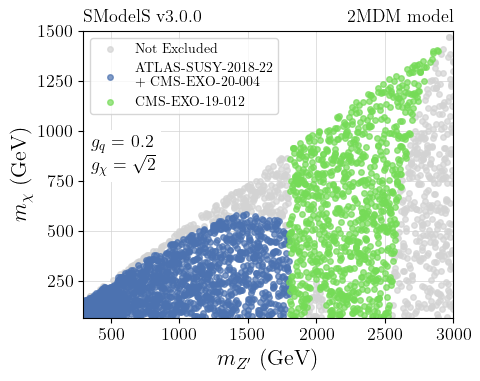

In [22]:
allowed = dataTotal[dataTotal['ExptRes.result0.r'] < 1.0]
x = allowed['mZp']
y = allowed['mChi']
scAll = plt.scatter(x,y,color='lightgray', label='Not Excluded', alpha=0.7)
ntot = len(x)

# Group by analysis type
anaTypes = dataTotal.groupby(by='anaType')

# Sort analyses by length of name and then length of points
for ana,anadf in sorted(anaTypes, key = lambda x: len(x[0])):
    excludedAna = anadf[anadf['ExptRes.result0.r'] > 1.0]
    if len(excludedAna) == 0:
        continue
    x = excludedAna['mZp']
    y = excludedAna['mChi']
    sc = plt.scatter(x,y,color=colorDict[ana], label=legendsDict[ana], alpha=0.7)
    ntot += len(x)

print(f'{ntot} points plotted')
plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
textstr = '\n'.join((
    r'$g_q =$ %1.1f' %gq, 
    r'$g_{\chi} = \sqrt{2}$'))

plt.text(0.02,0.51,textstr,
         bbox=dict(facecolor='white', edgecolor='none',alpha=1.0),transform = plt.gca().transAxes)

plt.xlim(300, 3000)
plt.ylim(65, 1500)

plt.legend()
plt.tight_layout()
plt.savefig('./figures/monojet-dijet-default-couplings_v1.png')
plt.show()